# <div align="center"> 梯度算法实现 </div>

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
np.random.seed(888)

## 激活函数及导函数

In [4]:
#####################################################################################
# <codecell> activity function and derivative function
#####################################################################################

def sigmoid(x):
    return 1 / (1 + np.exp(-1 * x))

def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

##

def tanh(x):
    return np.tanh(x)

def d_tanh(x):
    return 1 - np.tanh(x) ** 2

##

def relu(x):
    mask = (x > 0.0) * 1.0
    return x * mask

def d_relu(x):
    mask = (x > 0.0) * 1.0
    return mask

##

def elu(matrix):
    mask = (matrix <= 0) * 1.0
    less_zero = matrix * mask
    safe = (matrix > 0) * 1.0
    greater_zero = matrix * safe
    final = 3.0 * (np.exp(less_zero) - 1) * less_zero
    return greater_zero + final

def d_elu(matrix):
    safe = (matrix > 0) * 1.0
    mask2 = (matrix <= 0) * 1.0
    temp = matrix * mask2
    final = (3.0 * np.exp(temp))*mask2
    return (matrix * safe) + final

## 训练数据及标签

In [5]:
#####################################################################################
# <codecell> train data
#####################################################################################

mnist = input_data.read_data_sets("/home/lidong/Datasets/ML/mnist", one_hot=False)
train = mnist.test
images, labels = train.images, train.labels

images.shape, labels.shape, labels[0:5]

## select 0,1 labels and images

zero_index, one_index = np.where(labels == 0)[0], np.where(labels == 1)[0]
zero_image, one_image = images[[zero_index]], images[[one_index]]
zero_label, one_label = np.expand_dims(labels[[zero_index]], axis=1), \
                        np.expand_dims(labels[[one_index]], axis=1)

zero_image.shape, one_image.shape, zero_label.shape, one_label.shape

## meld 0, 1 labels and images

images_org = np.vstack((zero_image, one_image))
labels_org = np.vstack((zero_label, one_label))
images_org.shape, labels_org.shape, labels_org[2:5], labels[2:5]

## shuffle method 1: sklearn.utils.shuffle

images, labels = shuffle(images_org, labels_org)
images.shape, labels.shape

## shuffle method 2: np.random.shuffle

# images_labels = np.hstack((images_org, labels_org))
# np.random.shuffle(images_labels)
# images, labels = images_labels[:, 0:-1], np.expand_dims(images_labels[:, -1], axis=1)
# images.shape, labels.shape

## train / test data

train_num, test_num = 50, 20
train_images, train_labels = images[0:train_num, :], labels[0:train_num, :]
test_images, test_labels = images[-test_num-1:-1, :], labels[-test_num-1:-1, :]
train_images.shape, test_images.shape

## 算法模型

In [6]:
#####################################################################################
# <codecell> Graph
#####################################################################################
#
#      *****
#      * x *                     elu
#      *****               *****  l1A
#                          *   *                     tanh
#                          *****              *****   l2A
#      *****                                  *   *
#      *   *               *****              *****                   sigmoid
#      *****               *   *                                 *****   l3A
#              -------->   *****    -------->         -------->  *   *
#        .                                      .                *****
#             w1:784x256     .     w2:256x128   .     w3:128x1
#        .                   .                  .
#                            .
#        .                                    *****
#                          *****              *   *
#                          *   *              *****
#      *****               *****
#      *   *
#      *****
#      1x784               1x256               1x128               1x1
#      input              layer-1             layer-2            layer-3
#
# 损失函数:
#
#        (sigmoid(w3 * tanh(w2 * elu(w1 * x))) - label)^2 * 0.2
#           |     |     |   |     |  ------ x d(w1)
#           |     |     |   |     |    l1
#           |     |     |   |     +-------- d_elu(l1) d(l1)
#           |     |     |   |       l1A
#           |     |     |   +-------------- l1A d(w2)
#           |     |     |         l2
#           |     |     +------------------ d_tanh(l2) d(l2)
#           |     |            l2A
#           |     +------------------------ l2A d_sigmoid(l3) (l3A - label) d(w3) |
#           |               l3                                                    |
#           +------------------------------     d_sigmoid(l3) (l3A - label) d(l3) |w3
#                       l3A                                                       |
#         --------------------------------------------------- (l3A - label) d(l3A)|
#                                cost
#
#
# 0-9数字图像只选取了0和1, 所以简化模型, 采用全连接, 加最后一层的sigmoid,而不是softmax
# 矩阵求导是个难点, 需要基本的了解, 否则代码是很难理解, 什么时候转置, 什么时候点乘等.

## 全局参数

In [7]:
#####################################################################################
# <codecell> Global param
#####################################################################################

## weight

_w1 = np.random.randn(784, 256) * 0.2
_w2 = np.random.randn(256, 128) * 0.2
_w3 = np.random.randn(128, 1) * 0.2

## hyper parameters

learn_rate = 0.0003
num_epoch = 100
cost_array = {}

## SGD

In [8]:
#####################################################################################
# <codecell> SGD
#####################################################################################

w1, w2, w3 = _w1, _w2, _w3

cost_temp_array = []
for iter in range(num_epoch):
    total_cost = 0
    for index in range(len(train_images)):
        image = np.expand_dims(train_images[index], axis=0)
        label = np.expand_dims(train_labels[index], axis=1)

        # layer1
        l1 = image.dot(w1)
        l1A = elu(l1)

        # layer2
        l2 = l1A.dot(w2)
        l2A = tanh(l2)

        # layer3
        l3 = l2A.dot(w3)
        l3A = sigmoid(l3)

        # loss
        total_cost += np.square(l3A - label).sum() * 0.5

        # eval gradient
        g31 = l3A - label
        g32 = d_sigmoid(l3)
        g33 = l2A
        g3 = g33.T.dot(g31 * g32)   # 128x1

        g21 = (g31 * g32).dot(w3.T)
        g22 = d_tanh(l2)
        g23 = l1A
        g2 = g23.T.dot(g21 * g22)   # 256x128

        g11 = (g21 * g22).dot(w2.T)
        g12 = d_elu(l1)
        g13 = image
        g1 = g13.T.dot(g11 * g12)   # 784x256

        # update weight
        w3 = w3 - learn_rate * g3
        w2 = w2 - learn_rate * g2
        w1 = w1 - learn_rate * g1

    if iter % 10 == 0:
        print("SGD current Iter: ", iter, " Total Cost: ", total_cost)
    cost_temp_array.append(total_cost)
cost_array['sgd'] = cost_temp_array

SGD current Iter:  0  Total Cost:  6.536087150676306
SGD current Iter:  10  Total Cost:  4.7039394768622405
SGD current Iter:  20  Total Cost:  3.5608437208651247
SGD current Iter:  30  Total Cost:  2.8194669282531857
SGD current Iter:  40  Total Cost:  2.2232067357410785
SGD current Iter:  50  Total Cost:  1.773685538844725
SGD current Iter:  60  Total Cost:  1.4414821409916552
SGD current Iter:  70  Total Cost:  1.1979211742848752
SGD current Iter:  80  Total Cost:  1.0160552400127763
SGD current Iter:  90  Total Cost:  0.8750329832254002


## Momentum

In [9]:
#####################################################################################
# <codecell> Momentum
#####################################################################################

w1, w2, w3 = _w1, _w2, _w3
v1, v2, v3 = 0, 0, 0
alpha = 0.001

cost_temp_array = []
for iter in range(num_epoch):
    total_cost = 0
    for index in range(len(train_images)):
        image = np.expand_dims(train_images[index], axis=0)
        label = np.expand_dims(train_labels[index], axis=1)

        l1 = image.dot(w1)
        l1A = elu(l1)

        l2 = l1A.dot(w2)
        l2A = tanh(l2)

        l3 = l2A.dot(w3)
        l3A = sigmoid(l3)

        total_cost += np.square(l3A - label).sum() * 0.5

        g31 = l3A - label
        g32 = d_sigmoid(l3)
        g33 = l2A
        g3 = g33.T.dot(g31 * g32)

        g21 = (g31 * g32).dot(w3.T)
        g22 = d_tanh(l2)
        g23 = l1A
        g2 = g23.T.dot(g21 * g22)

        g11 = (g21 * g22).dot(w2.T)
        g12 = d_elu(l1)
        g13 = image
        g1 = g13.T.dot(g11 * g12)

        v3 = v3 * alpha + learn_rate * g3
        v2 = v2 * alpha + learn_rate * g2
        v1 = v1 * alpha + learn_rate * g1

        w3 = w3 - v3
        w2 = w2 - v2
        w1 = w1 - v1
    if iter % 10 == 0:
        print("Momentum current Iter: ", iter, " Total Cost: ", total_cost)
    cost_temp_array.append(total_cost)
cost_array['Momentum'] = cost_temp_array

Momentum current Iter:  0  Total Cost:  6.5360282734808886
Momentum current Iter:  10  Total Cost:  4.702489119548017
Momentum current Iter:  20  Total Cost:  3.559091644015248
Momentum current Iter:  30  Total Cost:  2.8175599262177844
Momentum current Iter:  40  Total Cost:  2.2210946534889504
Momentum current Iter:  50  Total Cost:  1.7716465695323558
Momentum current Iter:  60  Total Cost:  1.4398028082048022
Momentum current Iter:  70  Total Cost:  1.1965104244750853
Momentum current Iter:  80  Total Cost:  1.0148164340525612
Momentum current Iter:  90  Total Cost:  0.8739691541636565


## NAG

In [10]:
#####################################################################################
# <codecell> NAG: Nesterov accelerated gradient
#####################################################################################

w1, w2, w3 = _w1, _w2, _w3
v1, v2, v3 = 0, 0, 0
alpha = 0.001

cost_temp_array = []
for iter in range(num_epoch):
    total_cost = 0
    for index in range(len(train_images)):
        image = np.expand_dims(train_images[index], axis=0)
        label = np.expand_dims(train_labels[index], axis=1)

        l1 = image.dot(w1)
        l1A = elu(l1)

        l2 = l1A.dot(w2)
        l2A = tanh(l2)

        l3 = l2A.dot(w3)
        l3A = sigmoid(l3)

        total_cost += np.square(l3A - label).sum() * 0.5

        # 预知的能力, 提前使用动量的信息, 然后预知下一时刻的梯度
        fake_w3 = w3 - alpha * v3
        fake_w2 = w2 - alpha * v2
        fake_w1 = w1 - alpha * v1

        l1 = image.dot(fake_w1)
        l1A = elu(l1)

        l2 = l1A.dot(fake_w2)
        l2A = tanh(l2)

        l3 = l2A.dot(fake_w3)
        l3A = sigmoid(l3)

        g31 = l3A - label
        g32 = d_sigmoid(l3)
        g33 = l2A
        g3_fake = g33.T.dot(g31 * g32)

        g21 = (g31 * g32).dot(fake_w3.T)
        g22 = d_tanh(l2)
        g23 = l1A
        g2_fake = g23.T.dot(g21 * g22)

        g11 = (g21 * g22).dot(fake_w2.T)
        g12 = d_elu(l1)
        g13 = image
        g1_fake = g13.T.dot(g11 * g12)

        v3 = v3 * alpha + learn_rate * g3_fake
        v2 = v2 * alpha + learn_rate * g2_fake
        v1 = v1 * alpha + learn_rate * g1_fake

        w3 = w3 - v3
        w2 = w2 - v2
        w1 = w1 - v1
    if iter % 10 == 0:
        print("Nesterov accelerated gradient current Iter: ", iter, " Total Cost: ", total_cost)
    cost_temp_array.append(total_cost)
cost_array['NAG'] = cost_temp_array

Nesterov accelerated gradient current Iter:  0  Total Cost:  6.536028295188458
Nesterov accelerated gradient current Iter:  10  Total Cost:  4.7024892734738035
Nesterov accelerated gradient current Iter:  20  Total Cost:  3.5590915657097213
Nesterov accelerated gradient current Iter:  30  Total Cost:  2.817559539393665
Nesterov accelerated gradient current Iter:  40  Total Cost:  2.2210936943521706
Nesterov accelerated gradient current Iter:  50  Total Cost:  1.7716457247952035
Nesterov accelerated gradient current Iter:  60  Total Cost:  1.4398017094252133
Nesterov accelerated gradient current Iter:  70  Total Cost:  1.1965087859645642
Nesterov accelerated gradient current Iter:  80  Total Cost:  1.0148145176892138
Nesterov accelerated gradient current Iter:  90  Total Cost:  0.8739675344007252


## Adagrad

In [11]:
#####################################################################################
# <codecell> Adagrad
#####################################################################################

w1, w2, w3 = _w1, _w2, _w3

vlr_1, vlr_2, vlr_3 = 0, 0, 0
epsilon = 0.00000001

cost_temp_array = []
for iter in range(num_epoch):
    total_cost = 0
    for index in range(len(train_images)):
        image = np.expand_dims(train_images[index], axis=0)
        label = np.expand_dims(train_labels[index], axis=1)

        l1 = image.dot(w1)
        l1A = elu(l1)

        l2 = l1A.dot(w2)
        l2A = tanh(l2)

        l3 = l2A.dot(w3)
        l3A = sigmoid(l3)

        total_cost += np.square(l3A - label).sum() * 0.5

        g31 = l3A - label
        g32 = d_sigmoid(l3)
        g33 = l2A
        g3 = g33.T.dot(g31 * g32)

        g21 = (g31 * g32).dot(w3.T)
        g22 = d_tanh(l2)
        g23 = l1A
        g2 = g23.T.dot(g21 * g22)

        g11 = (g21 * g22).dot(w2.T)
        g12 = d_elu(l1)
        g13 = image
        g1 = g13.T.dot(g11 * g12)

        # 累加梯度平方, 自适应
        vlr_3 = vlr_3 + g3 ** 2  # 128x1
        vlr_2 = vlr_2 + g2 ** 2  # 256x128
        vlr_1 = vlr_1 + g1 ** 2  # 784x256

        w3 = w3 - (learn_rate / np.sqrt(vlr_3 + epsilon)) * g3
        w2 = w2 - (learn_rate / np.sqrt(vlr_2 + epsilon)) * g2
        w1 = w1 - (learn_rate / np.sqrt(vlr_1 + epsilon)) * g1
    if iter % 10 == 0:
        print("Adagrad current Iter: ", iter, " Total Cost: ", total_cost)
    cost_temp_array.append(total_cost)

cost_array['Adagrad'] = cost_temp_array

Adagrad current Iter:  0  Total Cost:  6.666279980434833
Adagrad current Iter:  10  Total Cost:  5.938413756637069
Adagrad current Iter:  20  Total Cost:  5.5551501935017376
Adagrad current Iter:  30  Total Cost:  5.362340744469407
Adagrad current Iter:  40  Total Cost:  5.20170269514624
Adagrad current Iter:  50  Total Cost:  4.994427581189343
Adagrad current Iter:  60  Total Cost:  4.849805978705678
Adagrad current Iter:  70  Total Cost:  4.813890657118094
Adagrad current Iter:  80  Total Cost:  4.8387691617087905
Adagrad current Iter:  90  Total Cost:  4.888179423498649


## Adadelta

In [12]:
#####################################################################################
# <codecell> Adadelta
#####################################################################################

w1, w2, w3 = _w1, _w2, _w3

epsilon, gamma = 0.000001, 0.001
vlr_1, vlr_2, vlr_3 = 0, 0, 0
wlr_1, wlr_2, wlr_3 = 0, 0, 0

cost_temp_array = []
for iter in range(num_epoch):
    total_cost = 0
    for index in range(len(train_images)):
        image = np.expand_dims(train_images[index], axis=0)
        label = np.expand_dims(train_labels[index], axis=1)

        l1 = image.dot(w1)
        l1A = elu(l1)

        l2 = l1A.dot(w2)
        l2A = tanh(l2)

        l3 = l2A.dot(w3)
        l3A = sigmoid(l3)

        total_cost += np.square(l3A - label).sum() * 0.5

        g31 = l3A - label
        g32 = d_sigmoid(l3)
        g33 = l2A
        g3 = g33.T.dot(g31 * g32)

        g21 = (g31 * g32).dot(w3.T)
        g22 = d_tanh(l2)
        g23 = l1A
        g2 = g23.T.dot(g21 * g22)

        g11 = (g21 * g22).dot(w2.T)
        g12 = d_elu(l1)
        g13 = image
        g1 = g13.T.dot(g11 * g12)

        # 梯度平方和衰减平均
        vlr_3 = gamma * vlr_3 + (1-gamma) * g3 ** 2
        vlr_2 = gamma * vlr_2 + (1-gamma) * g2 ** 2
        vlr_1 = gamma * vlr_1 + (1-gamma) * g1 ** 2

        delta_3 = - (np.sqrt(wlr_3 + epsilon) / np.sqrt(vlr_3 + epsilon)) * g3
        delta_2 = - (np.sqrt(wlr_2 + epsilon) / np.sqrt(vlr_2 + epsilon)) * g2
        delta_1 = - (np.sqrt(wlr_1 + epsilon) / np.sqrt(vlr_1 + epsilon)) * g1

        # Delta权重平方和衰减平均
        wlr_3 = gamma * wlr_3 + (1-gamma) * delta_3 ** 2
        wlr_2 = gamma * wlr_2 + (1-gamma) * delta_2 ** 2
        wlr_1 = gamma * wlr_1 + (1-gamma) * delta_1 ** 2

        w3 = w3 + delta_3
        w2 = w2 + delta_2
        w1 = w1 + delta_1
    if iter % 10 == 0:
        print("Adadelta current Iter: ", iter, " Total Cost: ", total_cost)
    cost_temp_array.append(total_cost)
cost_array['Adadelta'] = cost_temp_array

Adadelta current Iter:  0  Total Cost:  5.555458382436835
Adadelta current Iter:  10  Total Cost:  0.4173872280606051
Adadelta current Iter:  20  Total Cost:  0.015685602889927472
Adadelta current Iter:  30  Total Cost:  0.0004999529952571813
Adadelta current Iter:  40  Total Cost:  0.0003014010172245164
Adadelta current Iter:  50  Total Cost:  0.00021961229959164516
Adadelta current Iter:  60  Total Cost:  0.00017429757669405315
Adadelta current Iter:  70  Total Cost:  0.0001455897805569645
Adadelta current Iter:  80  Total Cost:  0.0001257113900228519
Adadelta current Iter:  90  Total Cost:  0.00011102101372915368


## RMSprop

In [13]:
#####################################################################################
# <codecell> RMSprop: 是Adadelta一个特殊情况
#####################################################################################

w1, w2, w3 = _w1, _w2, _w3

epsilon, gamma = 0.00000001, 0.9
vlr_1, vlr_2, vlr_3 = 0, 0, 0

cost_temp_array = []
for iter in range(num_epoch):
    total_cost = 0
    for index in range(len(train_images)):
        image = np.expand_dims(train_images[index], axis=0)
        label = np.expand_dims(train_labels[index], axis=1)

        l1 = image.dot(w1)
        l1A = elu(l1)

        l2 = l1A.dot(w2)
        l2A = tanh(l2)

        l3 = l2A.dot(w3)
        l3A = sigmoid(l3)

        total_cost += np.square(l3A - label).sum() * 0.5

        g31 = l3A - label
        g32 = d_sigmoid(l3)
        g33 = l2A
        g3 = g33.T.dot(g31 * g32)

        g21 = (g31 * g32).dot(w3.T)
        g22 = d_tanh(l2)
        g23 = l1A
        g2 = g23.T.dot(g21 * g22)

        g11 = (g21 * g22).dot(w2.T)
        g12 = d_elu(l1)
        g13 = image
        g1 = g13.T.dot(g11 * g12)

        vlr_3 = gamma * vlr_3 + (1 - gamma) * g3 ** 2
        vlr_2 = gamma * vlr_2 + (1 - gamma) * g2 ** 2
        vlr_1 = gamma * vlr_1 + (1 - gamma) * g1 ** 2

        w3 = w3 - (learn_rate/np.sqrt(vlr_3 + epsilon)) * g3
        w2 = w2 - (learn_rate/np.sqrt(vlr_2 + epsilon)) * g2
        w1 = w1 - (learn_rate/np.sqrt(vlr_1 + epsilon)) * g1
    if iter % 10 == 0:
        print("RMSprop current Iter: ", iter, " Total Cost: ", total_cost)
    cost_temp_array.append(total_cost)
cost_array['RMSprop'] = cost_temp_array

RMSprop current Iter:  0  Total Cost:  6.662123251715308
RMSprop current Iter:  10  Total Cost:  6.0221590057746495
RMSprop current Iter:  20  Total Cost:  0.18023272092255807
RMSprop current Iter:  30  Total Cost:  0.0008802990872975141
RMSprop current Iter:  40  Total Cost:  0.00024211243160348058
RMSprop current Iter:  50  Total Cost:  0.00014384174440690018
RMSprop current Iter:  60  Total Cost:  0.00010473995056811312
RMSprop current Iter:  70  Total Cost:  8.26706148535364e-05
RMSprop current Iter:  80  Total Cost:  6.840295279388158e-05
RMSprop current Iter:  90  Total Cost:  5.839048601164011e-05


## Adam

In [14]:
#####################################################################################
# <codecell> Adam (自适应矩估计, 一阶均值, 二阶方差(非中心)
#####################################################################################

w1, w2, w3 = _w1, _w2, _w3

epsilon, beta_1, beta_2 = 0.00000001, 0.9, 0.999
mlr_1, mlr_2, mlr_3 = 0, 0, 0
vlr_1, vlr_2, vlr_3 = 0, 0, 0

cost_temp_array = []
for iter in range(num_epoch):
    total_cost = 0
    for index in range(len(train_images)):
        image = np.expand_dims(train_images[index], axis=0)
        label = np.expand_dims(train_labels[index], axis=1)

        l1 = image.dot(w1)
        l1A = elu(l1)

        l2 = l1A.dot(w2)
        l2A = tanh(l2)

        l3 = l2A.dot(w3)
        l3A = sigmoid(l3)

        total_cost += np.square(l3A - label).sum() * 0.5

        g31 = l3A - label
        g32 = d_sigmoid(l3)
        g33 = l2A
        g3 = g33.T.dot(g31 * g32)

        g21 = (g31 * g32).dot(w3.T)
        g22 = d_tanh(l2)
        g23 = l1A
        g2 = g23.T.dot(g21 * g22)

        g11 = (g21 * g22).dot(w2.T)
        g12 = d_elu(l1)
        g13 = image
        g1 = g13.T.dot(g11 * g12)

        # 一阶mean: 梯度衰减均值
        mlr_3 = beta_1 * mlr_3 + (1 - beta_1) * g3
        mlr_2 = beta_1 * mlr_2 + (1 - beta_1) * g2
        mlr_1 = beta_1 * mlr_1 + (1 - beta_1) * g1

        # 二阶variance: 梯度指数衰减(梯度平方衰减均值)
        vlr_3 = beta_2 * vlr_3 + (1 - beta_2) * g3 ** 2
        vlr_2 = beta_2 * vlr_2 + (1 - beta_2) * g2 ** 2
        vlr_1 = beta_2 * vlr_1 + (1 - beta_2) * g1 ** 2

        # 矫正
        mlr_3_hat = mlr_3 / (1 - beta_1)
        mlr_2_hat = mlr_2 / (1 - beta_1)
        mlr_1_hat = mlr_1 / (1 - beta_1)

        vlr_3_hat = vlr_3 / (1 - beta_2)
        vlr_2_hat = vlr_2 / (1 - beta_2)
        vlr_1_hat = vlr_1 / (1 - beta_2)

        w3 = w3 - (learn_rate / (np.sqrt(vlr_3_hat) + epsilon)) * mlr_3_hat
        w2 = w2 - (learn_rate / (np.sqrt(vlr_2_hat) + epsilon)) * mlr_2_hat
        w1 = w1 - (learn_rate / (np.sqrt(vlr_1_hat) + epsilon)) * mlr_1_hat

    if iter % 10 == 0:
        print("Adam current Iter: ", iter, " Total Cost: ", total_cost)
    cost_temp_array.append(total_cost)
cost_array['Adam'] = cost_temp_array

Adam current Iter:  0  Total Cost:  5.640137434732136
Adam current Iter:  10  Total Cost:  2.392271710256568
Adam current Iter:  20  Total Cost:  0.4739090894708882
Adam current Iter:  30  Total Cost:  0.18447750680346103
Adam current Iter:  40  Total Cost:  0.06851363326585835
Adam current Iter:  50  Total Cost:  0.0416372969439648
Adam current Iter:  60  Total Cost:  0.026212537209548022
Adam current Iter:  70  Total Cost:  0.01764994299786532
Adam current Iter:  80  Total Cost:  0.012945100492132884
Adam current Iter:  90  Total Cost:  0.009185203318895196


## Nadam

In [15]:
#####################################################################################
# <codecell> Nadam (incorporate NAG into Adam)
#####################################################################################

w1, w2, w3 = _w1, _w2, _w3

epsilon, beta_1, beta_2 = 0.00000001, 0.9, 0.999

mlr_1, mlr_2, mlr_3 = 0, 0, 0
vlr_1, vlr_2, vlr_3 = 0, 0, 0

cost_temp_array = []
for iter in range(num_epoch):
    total_cost = 0
    for index in range(len(train_images)):
        image = np.expand_dims(train_images[index], axis=0)
        label = np.expand_dims(train_labels[index], axis=1)

        l1 = image.dot(w1)
        l1A = elu(l1)

        l2 = l1A.dot(w2)
        l2A = tanh(l2)

        l3 = l2A.dot(w3)
        l3A = sigmoid(l3)

        total_cost += np.square(l3A - label).sum() * 0.5

        g31 = l3A - label
        g32 = d_sigmoid(l3)
        g33 = l2A
        g3 = g33.T.dot(g31 * g32)

        g21 = (g31 * g32).dot(w3.T)
        g22 = d_tanh(l2)
        g23 = l1A
        g2 = g23.T.dot(g21 * g22)

        g11 = (g21 * g22).dot(w2.T)
        g12 = d_elu(l1)
        g13 = image
        g1 = g13.T.dot(g11 * g12)

        mlr_3 = beta_1 * mlr_3 + (1 - beta_1) * g3
        mlr_2 = beta_1 * mlr_2 + (1 - beta_1) * g2
        mlr_1 = beta_1 * mlr_1 + (1 - beta_1) * g1

        vlr_3 = beta_2 * vlr_3 + (1 - beta_2) * g3 ** 2
        vlr_2 = beta_2 * vlr_2 + (1 - beta_2) * g2 ** 2
        vlr_1 = beta_2 * vlr_1 + (1 - beta_2) * g1 ** 2

        mlr_3_hat = mlr_3 / (1 - beta_1)
        mlr_2_hat = mlr_2 / (1 - beta_1)
        mlr_1_hat = mlr_1 / (1 - beta_1)

        vlr_3_hat = vlr_3 / (1 - beta_2)
        vlr_2_hat = vlr_2 / (1 - beta_2)
        vlr_1_hat = vlr_1 / (1 - beta_2)

        w3 = w3 - (learn_rate/(np.sqrt(vlr_3_hat) + epsilon)) * \
                    (beta_1 * mlr_3_hat + (((1 - beta_1) * g3) / (1 - beta_1)))
        w2 = w2 - (learn_rate/(np.sqrt(vlr_2_hat) + epsilon)) * \
                    (beta_1 * mlr_2_hat + (((1 - beta_1) * g2) / (1 - beta_1)))
        w1 = w1 - (learn_rate/(np.sqrt(vlr_1_hat) + epsilon)) * \
                    (beta_1 * mlr_1_hat + (((1 - beta_1) * g1) / (1 - beta_1)))
    if iter % 10 == 0:
        print("Nadam current Iter: ", iter, " Total Cost: ", total_cost)
    cost_temp_array.append(total_cost)
cost_array['Nadam'] = cost_temp_array

Nadam current Iter:  0  Total Cost:  5.683507533833745
Nadam current Iter:  10  Total Cost:  2.5065008758041527
Nadam current Iter:  20  Total Cost:  0.33268948826621214
Nadam current Iter:  30  Total Cost:  0.12755957942989032
Nadam current Iter:  40  Total Cost:  0.06942463072059477
Nadam current Iter:  50  Total Cost:  0.042654097292935206
Nadam current Iter:  60  Total Cost:  0.03002246915358719
Nadam current Iter:  70  Total Cost:  0.01976767512075325
Nadam current Iter:  80  Total Cost:  0.012825742523476345
Nadam current Iter:  90  Total Cost:  0.009174874285437812


## SGD with Gaussian Noise

In [16]:
#####################################################################################
# <codecell> SGD with Gaussian Noise
#####################################################################################

w1, w2, w3 = _w1, _w2, _w3

eta = 0.001

cost_temp_array = []
for iter in range(num_epoch):
    total_cost = 0
    for index in range(len(train_images)):

        image = np.expand_dims(train_images[index],axis=0)
        label = np.expand_dims(train_labels[index],axis=1)

        l1 = image.dot(w1)
        l1A = elu(l1)

        l2 = l1A.dot(w2)
        l2A = tanh(l2)

        l3 = l2A.dot(w3)
        l3A = sigmoid(l3)

        total_cost += np.square(l3A - label).sum() * 0.5

        g31 = l3A - label
        g32 = d_sigmoid(l3)
        g33 = l2A
        g3 = g33.T.dot(g31 * g32)

        g21 = (g31 * g32).dot(w3.T)
        g22 = d_tanh(l2)
        g23 = l1A
        g2 = g23.T.dot(g21 * g22)

        g11 = (g21 * g22).dot(w2.T)
        g12 = d_elu(l1)
        g13 = image
        g1 = g13.T.dot(g11 * g12)

        noise = np.random.normal(loc=0, scale=eta / (np.power((1 + iter), 0.55)))

        w3 = w3 - learn_rate * (g3 + noise)
        w2 = w2 - learn_rate * (g2 + noise)
        w1 = w1 - learn_rate * (g1 + noise)
    if iter % 10 == 0:
        print("SGD with Gaussian Noise current Iter: ", iter, " Total Cost: ", total_cost)
    cost_temp_array.append(total_cost)
cost_array['SGDGN'] = cost_temp_array

SGD with Gaussian Noise current Iter:  0  Total Cost:  6.536011294865201
SGD with Gaussian Noise current Iter:  10  Total Cost:  4.703792555740373
SGD with Gaussian Noise current Iter:  20  Total Cost:  3.5607525365811683
SGD with Gaussian Noise current Iter:  30  Total Cost:  2.8194896592760905
SGD with Gaussian Noise current Iter:  40  Total Cost:  2.223787791423323
SGD with Gaussian Noise current Iter:  50  Total Cost:  1.7739982937232945
SGD with Gaussian Noise current Iter:  60  Total Cost:  1.4419054404573248
SGD with Gaussian Noise current Iter:  70  Total Cost:  1.1983793067180164
SGD with Gaussian Noise current Iter:  80  Total Cost:  1.0165376507715156
SGD with Gaussian Noise current Iter:  90  Total Cost:  0.8754741487107224


## 绘制算法比较图

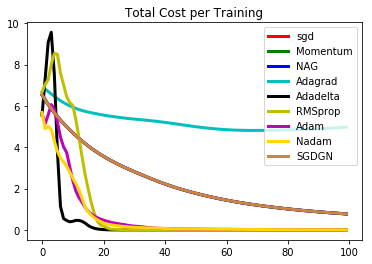

In [17]:
#####################################################################################
# <codecell> Plot
#####################################################################################

colors = ['r', 'g', 'b', 'c', 'k', 'y', 'm', 'gold', 'peru']

for i, (name, costs) in enumerate(cost_array.items()):
    plt.plot(np.arange(num_epoch), costs,
            color=colors[i], linewidth=3, label=name)
plt.title("Total Cost per Training")
plt.legend()